In [45]:
# ECE209AS Lab2
# Problem 1.
import numpy as np
import math

print('Dimensionality of the robot state space, and operational space is infinite')
print('Dimensionality of action space can be infinite, but we choose to implement the mov function within 5 actions')
print('Actions include forward, backward, turning left, turing right, and stay still')

# define the space for robot is 10m * 10m
W_Space = 16
L_Space = 16

W_Car = 0.9
L_Car = 1
D_Wheel = 0.5
Tail = 0.75

# direction of robot ranges from [0 , 2PI)
PI = math.pi
NORTH = 0
EAST = PI / 2
SOUTH = PI
WEST = 3 * PI / 2

sample_state = (5, 5, SOUTH) # A state will be a vector containing x_axis pos, y_axis pos, & direction.
# x_axis pos and y_axis pos are all in 1mm
sample_action = (0, 0) # An action will be a vector containing left_RPM & right_RPM

Dimensionality of the robot state space, and operational space is infinite
Dimensionality of action space can be infinite, but we choose to implement the mov function within 5 actions
Actions include forward, backward, turning left, turing right, and stay still


In [46]:
# Problem 2.a
def find_nearest(Set_V, Tar): # find nearest point towards Tar among some states in Set_V
    
    if Set_V == []:
        print('ERROR, INPUT STATES ARE EMPTY')
        return Tar

    comp_diff = 20000 # initialize difference
    nearest_state = Set_V[0]

    for s in Set_V:
        diff_x = Tar[0] - s[0]
        diff_y = Tar[1] - s[1]
        diff = math.sqrt(diff_x*diff_x + diff_y*diff_y)
        if diff < comp_diff:
            comp_diff = diff
            nearest_state = s
    
    return nearest_state

In [47]:
# Problem 2.b

# det_policy takes initial and desired state as input
# output a list containing 3 arrays: 
# pre-rotation "rotate the robot to align with moving direction" (clockwise, rotation time in 0.01s)
# mov "mov towards desired location" (robot's dir during movement, FWD, mov time in 0.01s)
# end_rotation "rotate the robot to achieve final state" (clockwise, rotation time in 0.01s)

# mov will be full speed 60, 60 or -60 -60
# rotation will be full speed 60 -60 (clockwise) or -60 60 (anticlockwise)

def det_policy(xi, xt):
    
    mov_len = math.sqrt((xt[1] - xi[1]) * (xt[1] - xi[1]) + (xt[0] - xi[0]) * (xt[0] - xi[0]))
    mov_t = mov_len / D_Wheel / PI * 10
    
    # mov_dir is the direction from initial position to final position
    mov_dir = 0
    # if infinity
    if xt[0] - xi[0] == 0:
        mov_dir = PI/2
    else:
        mov_dir = math.atan(((xt[1]-xi[1]) / (xt[0]-xi[0])))
        
    # deal with other half of circle
    if xt[0] - xi[0] < 0:
        mov_dir += PI
    mov_dir = mov_dir % (2*PI)
    mov_dir = PI/2 - mov_dir
    mov_dir = mov_dir % (2*PI)
    
    # division line among two initial and final direction    
    div_mid = ( xi[2] + xt[2] ) / 2
    if max(xi[2], xt[2]) - min(xi[2], xt[2]) > PI:
        div_mid = ( div_mid + PI ) % (2*PI)

    mov = 1
    if (mov_dir - ( div_mid + PI / 2 ) % (2*PI)) %(2*PI) < PI:
        mov = -1

    # act_dir is the direction of the robot during movement
    act_dir = ( mov_dir + (mov / 2 - 0.5) * PI ) % (2*PI)
    # if no movement
    if (xt[0] - xi[0] == 0) and (xt[1] - xi[1] == 0):
        act_dir = xi[2]
    
    pre_rot = 1 # initialize as clockwise
    pre_t = ((act_dir - xi[2]) % (2*PI)) / (D_Wheel/W_Car) / 2 / PI * 10
    if ( act_dir - xi[2] ) % (2*PI) > PI:
        pre_rot = -1
        pre_t = (( xi[2] - act_dir ) % (2*PI)) / (D_Wheel/W_Car) / 2 / PI * 10
                                                             
    end_rot = 1 # initialize as clockwise
    end_t = ((xt[2] - act_dir) % (2*PI)) / (D_Wheel/W_Car) / 2 / PI * 10
    if ( xt[2] - act_dir ) % (2*PI) > PI:
        end_rot = -1
        end_t = ((act_dir - xt[2]) % (2*PI)) / (D_Wheel/W_Car) / 2 / PI * 10
                                                         
    return [pre_rot, pre_t], [act_dir, mov, mov_t], [end_rot, end_t]

# generate_traj generates a series of states (at most 20) of robot during a 1 sec operation time
def generate_traj(xi, xt):
    
    traj = [] # define traj as states every 0.01s
    policy = det_policy(xi, xt)
    
    for i in range(11):
        if i < policy[0][1]:
            curr_dir = (xi[2] + i * policy[0][0] * 5/9 / 10 * 2 * PI) % (2*PI)
            traj.append((xi[0], xi[1], curr_dir))
            
        elif i < policy[0][1] + policy[1][2]:
            curr_x = xi[0] + math.sin(policy[1][0]) * (i - policy[0][1]) * 0.5 * PI * policy[1][1] / 10
            curr_y = xi[1] + math.cos(policy[1][0]) * (i - policy[0][1]) * 0.5 * PI * policy[1][1] / 10
            traj.append((curr_x, curr_y, policy[1][0]))
            
        elif i < policy[0][1] + policy[1][2] + policy[2][1]:
            curr_dir = ( policy[1][0] + (i - (policy[0][1] + policy[1][2])) * policy[2][0] * D_Wheel/W_Car / 10 * 2*PI ) % (2*PI)
            traj.append((xt[0], xt[1], curr_dir))
            
        else:
            traj.append(xt)
            break
            
    return traj

In [48]:
obstacleList = [ (0, 0, 0.5, 16),
            (0.5, 0, 15.5, 0.5),
            (15.5, 0.5, 0.5, 15.5),
            (0.5, 15.5, 15.0, 0.5),
            (3, 7.25, 10, 0.5),
            (3, 0.5, 1, 1),
            (4.5, 0.5, 1, 1),
            (10, 0.5, 1, 1),
            (7, 6, 1, 1),
            (14, 0.5, 1, 1),
            (9, 6, 1, 1),
            (4, 14, 1, 1),
            (6, 14, 1, 1),
            (9, 14, 1, 1),
            (8, 8, 1, 1)]
start = (2.0, 4.0, PI / 3)
goal = (11.0, 9.0, PI * 3 / 2)

In [49]:
# Define Obstacle States Here
def check_state_collision(s):
    
    if s[0] < 0.87 or s[0] > 16 - 0.87 or s[1] < 0.87 or s[1] > 16 - 0.87:
        return 1
    
    for i in range(len(obstacleList)):
        if s[0] < obstacleList[i][0] + obstacleList[i][2] + 0.87 and s[0] > obstacleList[i][0] - 0.87 and s[1] < obstacleList[i][1] + obstacleList[i][3] + 0.87 and s[1] > obstacleList[i][1] - 0.87:
            return 1
        
    return 0

In [50]:
# Problem 2.c
def check_collision(traj):
    if traj == []:
        print("ERROR EMPTY TRAJCTORY")
        return 0, (0, 0, 0)

    
    pre_s = traj[0]
    for i in range(len(traj)):
        if check_state_collision(traj[i]) == 1:
            return 1, pre_s
        pre_s = traj[i]
    return 0, pre_s    

In [51]:
#Problem 2.d
def rrt_planner(initial, final, k = 2000):
    """
    Args: trajectory finder
    """
    reach_goal = False
    node_on_tree = [initial]
    node_on_tree_dict = {}
    true_fin_state = final
    #initialize storage
    
    for i in range(k):
        approximity_to_goal = (final[0] - node_on_tree[-1][0]) * (final[0] - node_on_tree[-1][0]) + (final[1] - node_on_tree[-1][1])* (final[1] - node_on_tree[-1][1])

        if approximity_to_goal < 0.75: #!!!needs futher confirmation
            true_fin_state = node_on_tree[-1]
            reach_goal = True
            break
        #check if we have reached the goal
    
        rand_pos = (np.random.uniform(0, W_Space), 
                         np.random.uniform(0, L_Space),
                         np.random.uniform(0, 2*PI))
        
        
        near_pos = find_nearest(node_on_tree, rand_pos)
        #Then find the nearest shit
        
        last_traj = generate_traj(near_pos, rand_pos)
        
        (collision, pre_s) = check_collision(last_traj)
        if pre_s != near_pos:
            node_on_tree_dict[pre_s]  = near_pos
            node_on_tree.append(pre_s)
    
    if (reach_goal == False):
        return False, [], 0
            
    temp = true_fin_state
    path_list = [true_fin_state]
    while (node_on_tree_dict[temp] == initial) is False:
        if node_on_tree_dict[temp] == temp:
            print(temp)
            return False, [], 100
        temp = node_on_tree_dict[temp]
        path_list.append(temp)
    path_list.append(initial)

    length = 0
    traj = []
    for x in range(len(path_list) - 1):
        temptraj = generate_traj(path_list[len(path_list) - x - 1], path_list[len(path_list) - x - 2])
        traj += temptraj
        length += math.sqrt((temptraj[-1][0]-temptraj[0][0])*(temptraj[-1][0]-temptraj[0][0]) + (temptraj[-1][1]-temptraj[0][1])*(temptraj[-1][1]-temptraj[0][1]))
        
    return True, traj, length

In [52]:
def draw_robot(traj):
    if traj == []:
        return
    
    start = traj[0]
    end = traj[-1]
    ax = draw_Ospace(start, end, obstacleList)

    for i in range(len(traj)):
        theta = traj[i][2]
        degree = (PI / 2 - theta) / PI * 180
        rec_corner = [traj[i][0] + 0.87*cos(3*PI/2 + 0.6 - theta), traj[i][1]+0.87*sin(3*PI/2 + 0.6 - theta)]
        robot = plt.Rectangle(rec_corner, 1, 0.9, degree, facecolor='w', edgecolor='b')
        ax.add_patch(robot)

    plt.show()
    
    

In [53]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
from scipy.spatial import ConvexHull
from scipy.spatial import convex_hull_plot_2d
from numpy import cos, sin

def draw_Ospace(initial_state, goal_state, obstaclelist, mode=1):
    """ obstaclelist includes all obstacle infos 
    each obstacle (x, y, width, height) in which (x,y) is the left and bottom 
    coordinate of the rectangle and (width, height) is the range of the obstacle"""
    
    fig = plt.figure(figsize = (9, 9))
    ax = fig.add_subplot(1,1,1)
    plt.xlim((0, 16))
    plt.ylim((0, 16))
    plt.grid()
    
    # Plot initial (red) and goal (green) states
    if mode:
        plt.arrow(initial_state[0], initial_state[1], np.cos(PI/2-initial_state[2]),
              np.sin(PI/2-initial_state[2]), color='r', width=0.1)
        plt.arrow(goal_state[0], goal_state[1], np.cos(PI/2-goal_state[2]),
              np.sin(PI/2-goal_state[2]), color='g', width=0.1)
              
    # Plot the obstacles
    for ob in obstacleList:
        obstacle = plt.Rectangle(ob[0:2], ob[2], ob[3], color = 'k')
        ax.add_patch(obstacle)
    return ax

[(2.0, 4.0, 1.0471975511965976), (2.0, 4.0, 0.6981317007977317), (2.0684508918677427, 4.097245849719373, 0.6133354460504253), (2.158865639434385, 4.225695000846128, 0.6133354460504253), (2.249280387001028, 4.354144151972881, 0.6133354460504253), (2.33969513456767, 4.482593303099636, 0.6133354460504253), (2.4301098821343126, 4.61104245422639, 0.6133354460504253), (2.520524629700955, 4.739491605353144, 0.6133354460504253), (2.6109393772675977, 4.867940756479898, 0.6133354460504253), (2.70135412483424, 4.996389907606652, 0.6133354460504253), (2.7917688724008825, 5.124839058733406, 0.6133354460504253), (2.7917688724008825, 5.124839058733406, 0.6133354460504254), (2.7917688724008825, 5.124839058733406, 0.2642695956515595), (2.7917688724008825, 5.124839058733406, 6.1983890524322796), (2.7917688724008825, 5.124839058733406, 5.849323202033414), (2.7917688724008825, 5.124839058733406, 5.500257351634548), (2.8254742488254263, 5.105299131794551, 5.2377686956409715), (2.961369110809178, 5.02651717

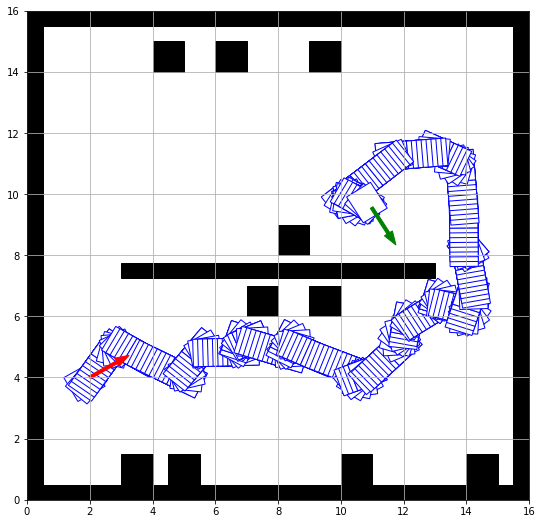

In [54]:
[rrt_traj, length] = rrt_planner(start, goal)[1:3]
print(rrt_traj)
print(length)
draw_robot(rrt_traj)

In [55]:
#Problem 2.d （pure path developer)
def rrt_path_finder(initial, final, k = 2000):
    """
    Args: trajectory finder
    """
    node_on_tree = [initial]
    node_on_tree_dict = {}
    #initialize storage
    
    for i in range(k):
        approximity_to_goal = (final[0] - node_on_tree[-1][0]) * (final[0] - node_on_tree[-1][0]) + (final[1] - node_on_tree[-1][1])* (final[1] - node_on_tree[-1][1])

        #check if we have reached the goal
    
        rand_pos = (np.random.uniform(0, W_Space), 
                         np.random.uniform(0, L_Space),
                         np.random.uniform(0, 2*PI))
        
        
        near_pos = find_nearest(node_on_tree, rand_pos)
        #Then find the nearest shit
        
        last_traj = generate_traj(near_pos, rand_pos)
        
        (collision, pre_s) = check_collision(last_traj)
        if pre_s != near_pos:
            node_on_tree_dict[pre_s]  = near_pos
            node_on_tree.append(pre_s)
   
    return node_on_tree_dict

In [56]:
def draw_rrt(node_on_tree_dict, cycle, color):
    ax = draw_Ospace(None, None, obstacleList, 0)
    counter = 0
    for k in node_on_tree_dict.keys():
        counter += 1
        arrow=plt.arrow(k[0], k[1], (node_on_tree_dict[k][0]-k[0]),
              (node_on_tree_dict[k][1]-k[1]), color=color, width=0.001)
        ax.add_patch(arrow)
        if counter == cycle:
            break
    '''
    for k in range(len(path_list)-1):
        plt.arrow(path_list[k][0], path_list[k][1], (path_list[k+1][0]-path_list[k][0]),
              (path_list[k+1][1]-path_list[k][1]), color='r', width=0.001)
    '''
    

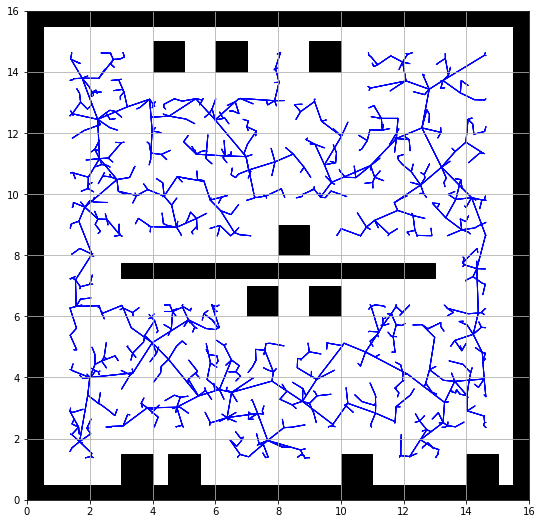

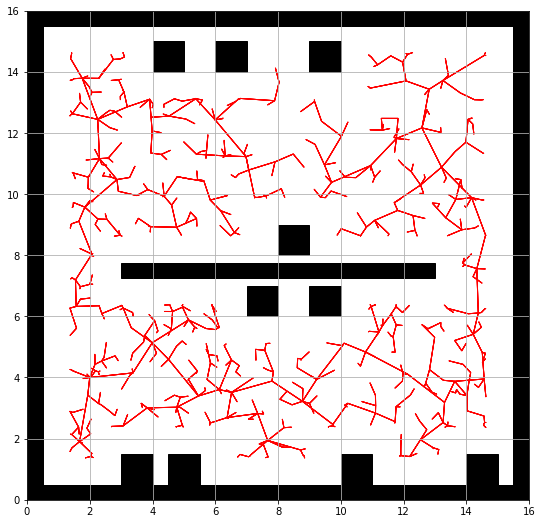

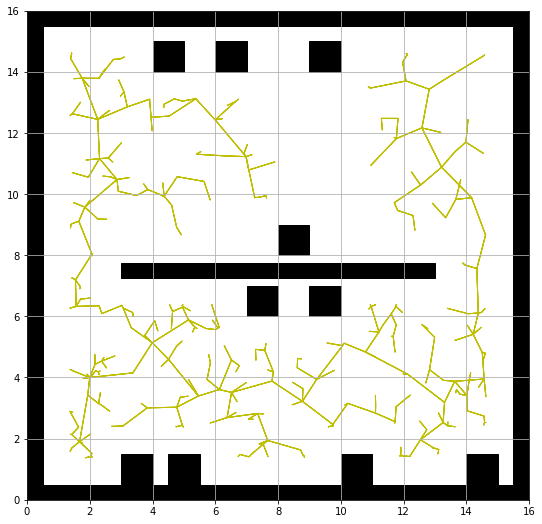

In [57]:
node_on_tree_dict = rrt_path_finder(start, goal, k=2000)
draw_rrt(node_on_tree_dict, 2000, 'b')
draw_rrt(node_on_tree_dict, 1000, 'r')
draw_rrt(node_on_tree_dict, 500, 'y')

In [60]:
#Problem 2.d
import random
def rrt_planner2(initial, final):
    """
    Args: trajectory finder
    """
    reach_goal = False
    node_on_tree = [initial]
    node_on_tree_dict = {}
    true_fin_state = final
    #initialize storage
    
    while True:
        if node_on_tree[-1] == true_fin_state:
            break
        #check if we have reached the goal
        
        if random.randint(1, 100) == 1:
            rand_pos =true_fin_state
        else:
            rand_pos = (np.random.uniform(0, W_Space), 
                             np.random.uniform(0, L_Space),
                             np.random.uniform(0, 2*PI))
        
        
        near_pos = find_nearest(node_on_tree, rand_pos)
        #Then find the nearest shit
        
        last_traj = generate_traj(near_pos, rand_pos)
        
        (collision, pre_s) = check_collision(last_traj)
        if pre_s != near_pos:
            node_on_tree_dict[pre_s]  = near_pos
            node_on_tree.append(pre_s)
    
    temp = true_fin_state
    path_list = [true_fin_state]
    while (node_on_tree_dict[temp] == initial) is False:
        if node_on_tree_dict[temp] == temp:
            print(temp)
            return False, [], 100
        temp = node_on_tree_dict[temp]
        path_list.append(temp)
    path_list.append(initial)

    length = 0
    traj = []
    for x in range(len(path_list) - 1):
        temptraj = generate_traj(path_list[len(path_list) - x - 1], path_list[len(path_list) - x - 2])
        traj += temptraj
        length += math.sqrt((temptraj[-1][0]-temptraj[0][0])*(temptraj[-1][0]-temptraj[0][0]) + (temptraj[-1][1]-temptraj[0][1])*(temptraj[-1][1]-temptraj[0][1]))
        
    return True, traj, length

[(2.0, 4.0, 1.0471975511965976), (2.0967814055789633, 4.06767543606241, 0.9605666908624279), (2.2255107477786837, 4.157690809524673, 0.9605666908624279), (2.354240089978404, 4.247706182986936, 0.9605666908624279), (2.482969432178124, 4.337721556449199, 0.9605666908624279), (2.6116987743778446, 4.427736929911462, 0.9605666908624279), (2.740428116577565, 4.517752303373725, 0.9605666908624279), (2.869157458777285, 4.607767676835989, 0.9605666908624279), (2.9978868009770054, 4.697783050298252, 0.9605666908624279), (3.1266161431767254, 4.787798423760515, 0.9605666908624279), (3.255345485376446, 4.877813797222778, 0.9605666908624279), (3.255345485376446, 4.877813797222778, 0.9605666908624282), (3.3172716156968205, 4.937619728796122, 0.8028133321379801), (3.4302610872833386, 5.046740718130543, 0.8028133321379801), (3.543250558869856, 5.155861707464965, 0.8028133321379801), (3.6562400304563742, 5.264982696799385, 0.8028133321379801), (3.7692295020428923, 5.3741036861338065, 0.8028133321379801)

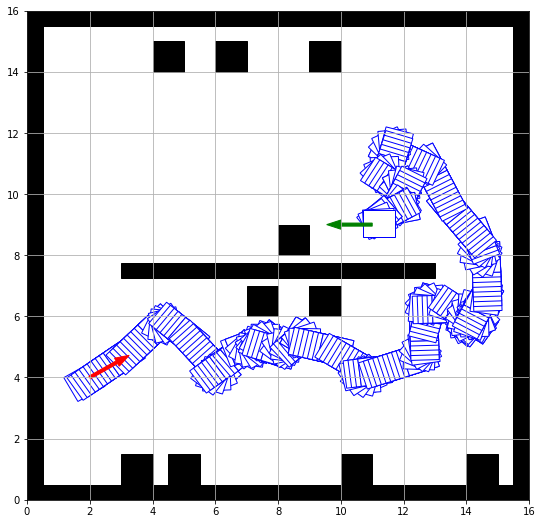

In [63]:
[rrt_traj, length] = rrt_planner2(start, goal)[1:3]
print(rrt_traj)
print(length)
draw_robot(rrt_traj)

[(2.0, 4.0, 1.0471975511965976), (2.0004811902797277, 4.000085385760677, 1.3951773853997118), (2.1551447163429787, 4.027529960969733, 1.3951773853997118), (2.309808242406229, 4.054974536178788, 1.3951773853997118), (2.46447176846948, 4.082419111387844, 1.3951773853997118), (2.619135294532731, 4.109863686596899, 1.3951773853997118), (2.773798820595982, 4.137308261805955, 1.3951773853997118), (2.9284623466592326, 4.16475283701501, 1.3951773853997118), (3.0831258727224835, 4.192197412224066, 1.3951773853997118), (3.2377893987857345, 4.219641987433121, 1.3951773853997118), (3.3924529248489854, 4.247086562642177, 1.3951773853997123), (3.3924529248489854, 4.247086562642177, 1.3951773853997123), (3.3924529248489854, 4.247086562642177, 1.0461115350008463), (3.447313612446146, 4.2944921748849, 0.8581680921100266), (3.566167301797909, 4.397194713948928, 0.8581680921100266), (3.685020991149672, 4.499897253012955, 0.8581680921100266), (3.8038746805014347, 4.602599792076982, 0.8581680921100266), (3

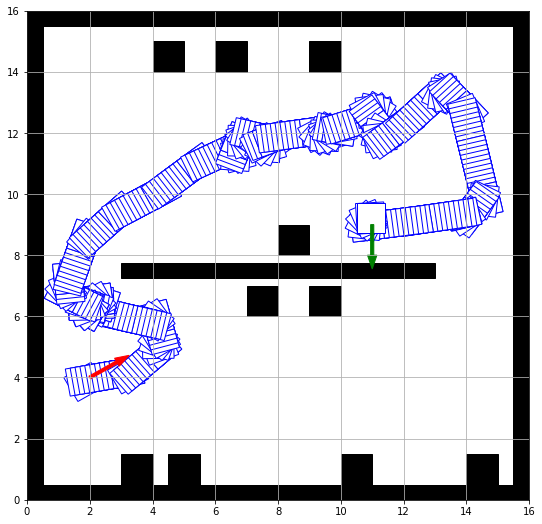

In [65]:
goal = (11.0, 9.0, PI)
[rrt_traj, length] = rrt_planner2(start, goal)[1:3]
print(rrt_traj)
print(length)
draw_robot(rrt_traj)

In [71]:
import time
length_left = []
time_left = []
length_down = []
time_down = []
start = (2.0, 4.0, PI / 3)
goal = (11.0, 9.0, PI * 3 / 2)

for k in range(100):
    start_time = time.time()
    length = rrt_planner2(start, goal)[2:3]
    end_time = time.time()
    time_left.append(end_time-start_time)
    length_left.append(length)
    
goal = (11.0, 9.0, PI)
for k in range(100):
    start_time = time.time()
    length = rrt_planner2(start, goal)[2:3]
    end_time = time.time()
    time_down.append(end_time-start_time)
    length_down.append(length)
    
print(length_left, '\n', time_left, '\n', length_down, '\n', time_down)

[(28.497551548212197,), (27.29661841804897,), (32.59243779293885,), (24.552861213276014,), (20.18960938320118,), (27.864431427358625,), (22.195981757432335,), (21.75915356842694,), (24.1422177318072,), (22.68973688338083,), (30.917950283086558,), (22.553279404979175,), (17.29417915230455,), (25.729962433276974,), (19.804634927663148,), (27.1463347145848,), (21.233784978082248,), (26.22245602648844,), (23.435802730306555,), (25.09011767398274,), (25.661294242117666,), (24.943686042012118,), (22.72289190973604,), (22.530674476962524,), (24.90463463636788,), (22.596669647502242,), (23.585691732078896,), (25.127474849419055,), (26.33052209482151,), (27.333079951203125,), (23.16619140260232,), (21.183427359155544,), (24.15057409033196,), (22.769632987675326,), (22.06347744412248,), (19.914993937392325,), (24.944036576428093,), (23.956270061988437,), (23.883836958245748,), (18.973609823318366,), (25.224198018028908,), (17.79151149190031,), (19.947987325621305,), (27.319842002689352,), (22.42

In [75]:
print("average and variance of length_left\n", np.mean(length_left), np.std(length_left))
print("average and variance of time_left\n", np.mean(time_left), np.std(time_left))
print("average and variance of length_down\n", np.mean(length_down), np.std(length_down))
print("average and variance of time_down\n", np.mean(time_down), np.std(time_down))

average and variance of length_left
 23.247725980504523 3.3648147270292212
average and variance of time_left
 0.03334511995315552 0.021688124776694795
average and variance of length_down
 23.37006849605375 3.109577101688192
average and variance of time_down
 0.036828594207763674 0.025971318824594563
